In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Lasso,Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
import warnings
warnings.filterwarnings("ignore")

In [71]:
train = pd.read_csv('/content/train.csv')

train.head()

,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,2,L49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,3,L53355,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,4,M24050,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0


In [51]:
train.Type.value_counts()

L    95354
M    32152
H     8923
Name: Type, dtype: int64

In [52]:
train.isna().sum()

id                         0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64

<Axes: >

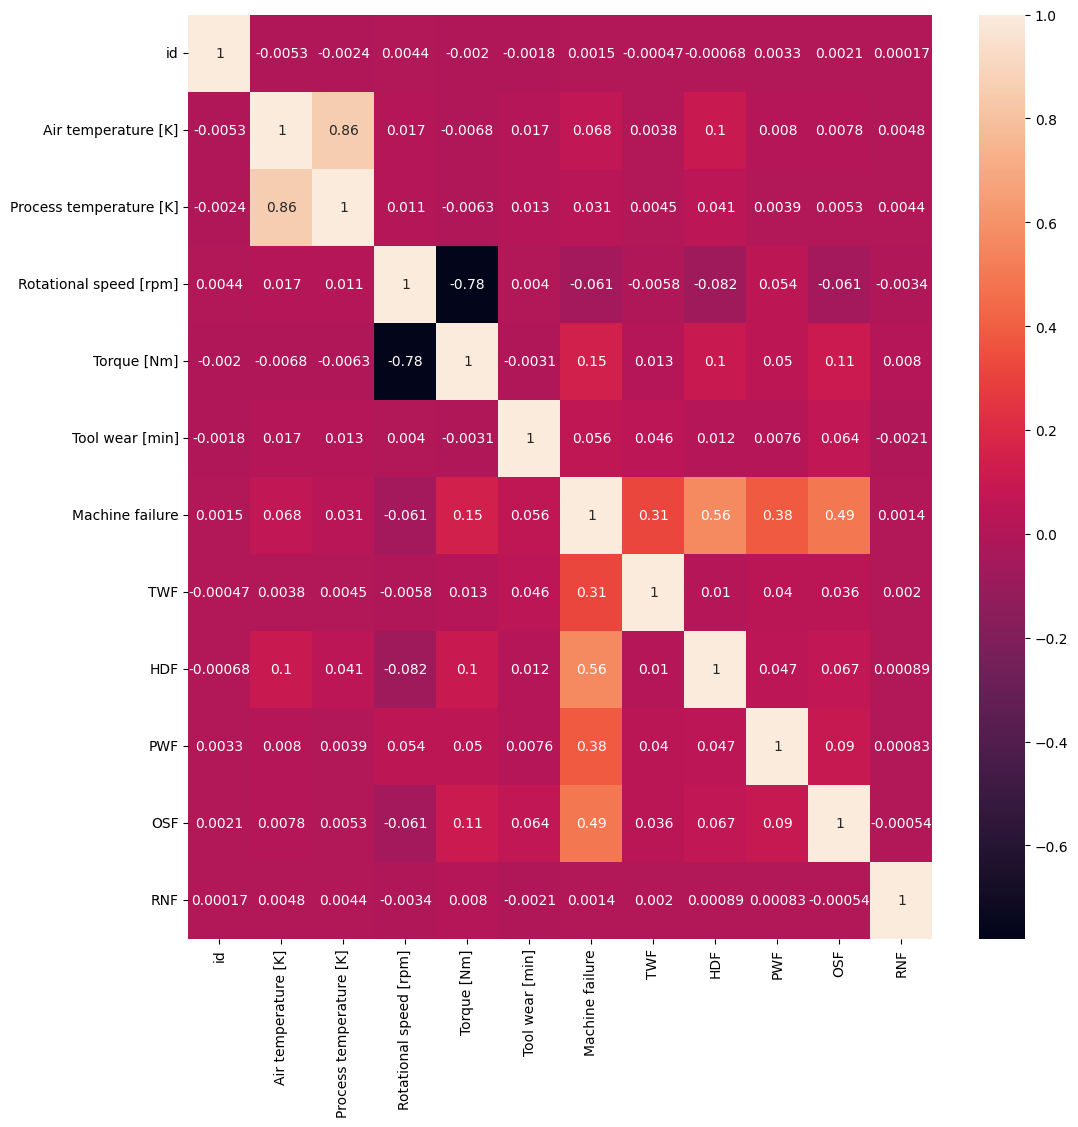

In [59]:
plt.rcParams['figure.figsize'] = [12,12]
sns.heatmap(train.corr(),annot=True)

In [72]:
def preprocess(df):
  le = LabelEncoder()
  df['Type'] = le.fit_transform(df['Type'])
  df.drop(['id','Product ID'],axis=1,inplace=True)
  df.rename(columns={'Air temperature [K]':'Air temperature','Process temperature [K]':'Process temperature',
                     'Rotational speed [rpm]':'Rotational speed','Torque [Nm]':'Torque','Tool wear [min]':'Tool wear'},inplace=True)
  df['Power'] = df['Torque'] * df['Rotational speed']
  df['Temperature Ratio'] = df['Air temperature'] / df['Process temperature']
  df.drop(['Torque','Rotational speed','Air temperature','Process temperature'],axis=1,inplace=True)
  return df

In [73]:
train = preprocess(train)

<Axes: >

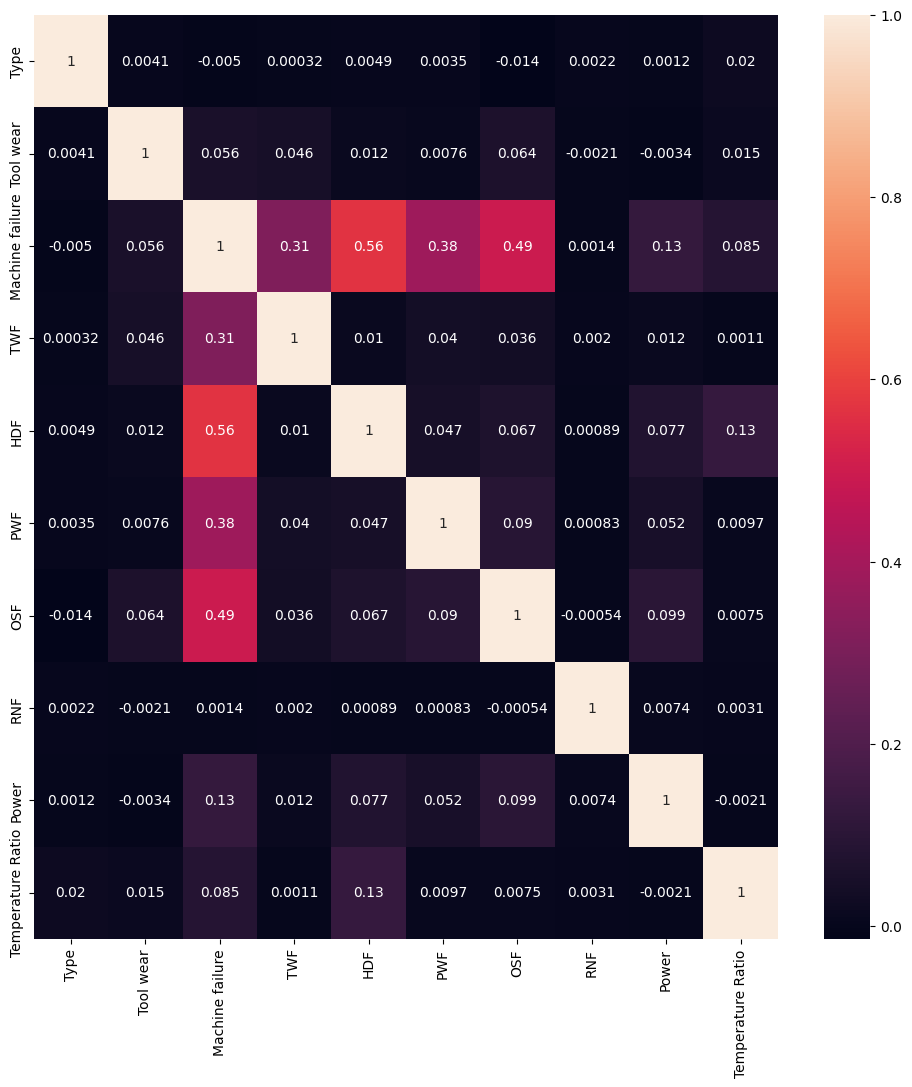

In [74]:
plt.rcParams['figure.figsize'] = [12,12]
sns.heatmap(train.corr(),annot=True)

In [76]:
X = train[['Type', 'Tool wear', 'TWF', 'HDF', 'PWF', 'OSF','RNF', 'Power', 'Temperature Ratio']]
y = train[ 'Machine failure']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

In [94]:
xgb = XGBRegressor(n_estimators=1000, learning_rate=0.02)
xgb.fit(X_train,y_train,early_stopping_rounds=25,eval_set=[(X_test,y_test)],verbose=75)

[0]	validation_0-rmse:0.49016
[75]	validation_0-rmse:0.12415
[150]	validation_0-rmse:0.06792
[225]	validation_0-rmse:0.06405
[276]	validation_0-rmse:0.06396


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.02, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [95]:
xgb.score(X_test,y_test)

0.7370887065059537

In [96]:
test = pd.read_csv('/content/test.csv')
testids = test['id']

In [97]:
test = preprocess(test)

In [98]:
preds = xgb.predict(test)

In [99]:
preds

array([0.00434476, 0.00434476, 0.00434476, ..., 0.0043176 , 0.0043176 ,
       0.00434476], dtype=float32)

In [100]:
sub_df = pd.DataFrame({'id':testids,'Machine failure':preds})

In [87]:
sub_df.to_csv('sub_df.csv',index=False)